In [ ]:
!pip install matplotlib keras_gpu_metrics tensorflow_datasets

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds

from keras_gpu_metrics import GPUMetricTrackerCallback

## Dataset Loading

In [2]:
(dataset,), ds_info = tfds.load(
    'bee_dataset/bee_dataset_300',
    split=['train'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

def normalize_img(image, label):
    """Normalizes images: `uint8` -> `float32`.  Stacks label fields into a multi-hot vector."""
    return (
        tf.cast(image, tf.float32) / 255.,
        tf.stack([label['cooling_output'], label['pollen_output'], label['varroa_output'], label['wasps_output']])
    )

dataset = dataset.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE).cache()
mnist_train = dataset.shuffle(ds_info.splits['train'].num_examples)
dataset = dataset.batch(64)
dataset = dataset.prefetch(tf.data.AUTOTUNE)

Label: [0. 0. 1. 0.]


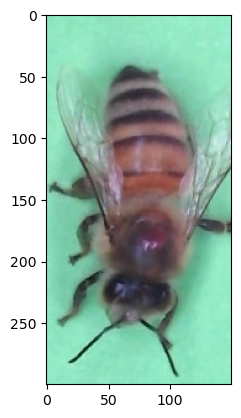

In [3]:
# Visualizes a single instance from the dataset
for input, label in dataset:
    break

example_index = 1

print(f'Label: {label[example_index].numpy()}')
plt.imshow(input[example_index]);

## Model Definition

In [4]:
# Defines a simple convolutional network, but powerful enough that training should warm up the GPU a little.
n_outputs = len(ds_info.features['output'])

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(4, (3, 3), activation='gelu', input_shape=(300, 150, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(8, (3, 3), activation='gelu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(16, (3, 3), activation='gelu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='gelu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='gelu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(n_outputs, activation='sigmoid'),
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 298, 148, 4)       112       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 149, 74, 4)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 147, 72, 8)        296       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 73, 36, 8)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 71, 34, 16)        1168      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 35, 17, 16)       0

## Training

In [5]:
# GPUMetricTrackerCallback is needed to update variables so that metrics
# (which are part of the tensorflow graph) can receive updated GPU info.
gpu_tracker_callback = GPUMetricTrackerCallback()

metrics = [
    tf.keras.metrics.BinaryAccuracy(),
    gpu_tracker_callback.utilization_metric(),
    gpu_tracker_callback.clock_speed_metric(),
    gpu_tracker_callback.temperature_metric(),
    gpu_tracker_callback.fan_speed_metric(),
    gpu_tracker_callback.power_usage_metric(),
]

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=metrics
)

In [6]:
history = model.fit(
    dataset,
    epochs=10,
    validation_data=dataset,
    callbacks=[gpu_tracker_callback]
)

Epoch 1/10
118/118 [==============================] - 8s 33ms/step - loss: 0.4380 - binary_accuracy: 0.8459 - gpu_0_utilization: 29.8305 - gpu_0_clock_speed: 1839.7881 - gpu_0_temperature: 49.4746 - gpu_0_fan_speed: 0.0000e+00 - gpu_0_power_usage: 165194.8594 - val_loss: 0.4138 - val_binary_accuracy: 0.8534 - val_gpu_0_utilization: 41.1017 - val_gpu_0_clock_speed: 1950.0000 - val_gpu_0_temperature: 55.7627 - val_gpu_0_fan_speed: 18.5593 - val_gpu_0_power_usage: 207710.9844
Epoch 2/10
118/118 [==============================] - 4s 31ms/step - loss: 0.4030 - binary_accuracy: 0.8536 - gpu_0_utilization: 40.4153 - gpu_0_clock_speed: 1942.3729 - gpu_0_temperature: 58.4831 - gpu_0_fan_speed: 30.0000 - gpu_0_power_usage: 213689.2188 - val_loss: 0.3589 - val_binary_accuracy: 0.8561 - val_gpu_0_utilization: 43.6271 - val_gpu_0_clock_speed: 1935.0000 - val_gpu_0_temperature: 59.8051 - val_gpu_0_fan_speed: 30.0000 - val_gpu_0_power_usage: 220158.2188
Epoch 3/10
118/118 [===========================

## Visualizing Metrics

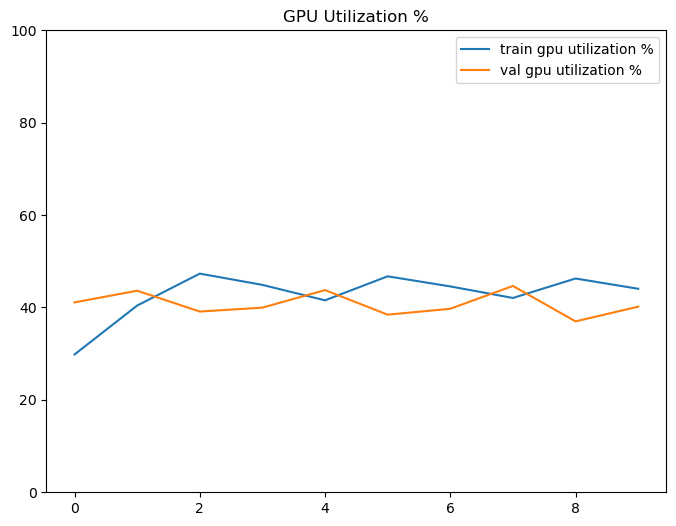

In [7]:
metric_history = history.history

fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title('GPU Utilization %')
ax.plot(metric_history['gpu_0_utilization'], label='train gpu utilization %')
ax.plot(metric_history['val_gpu_0_utilization'], label='val gpu utilization %')
ax.set_ylim(0, 100)
plt.legend()
plt.show();

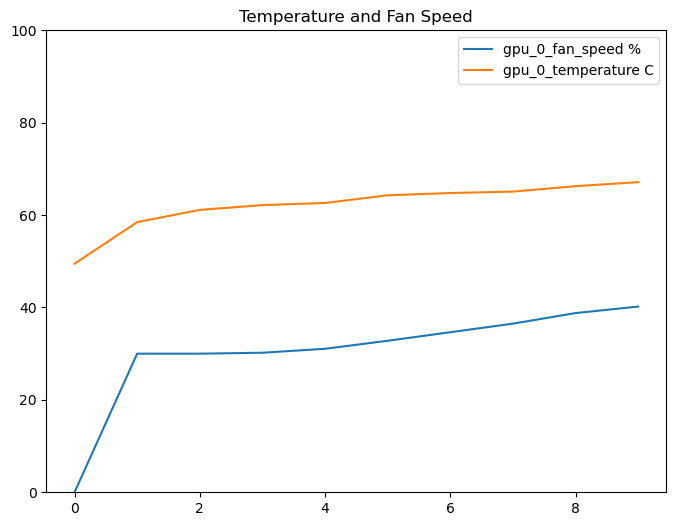

In [8]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title('Temperature and Fan Speed')
ax.plot(metric_history['gpu_0_fan_speed'], label='gpu_0_fan_speed %')
ax.plot(metric_history['gpu_0_temperature'], label='gpu_0_temperature C')
ax.set_ylim(0, 100)
plt.legend()
plt.show();

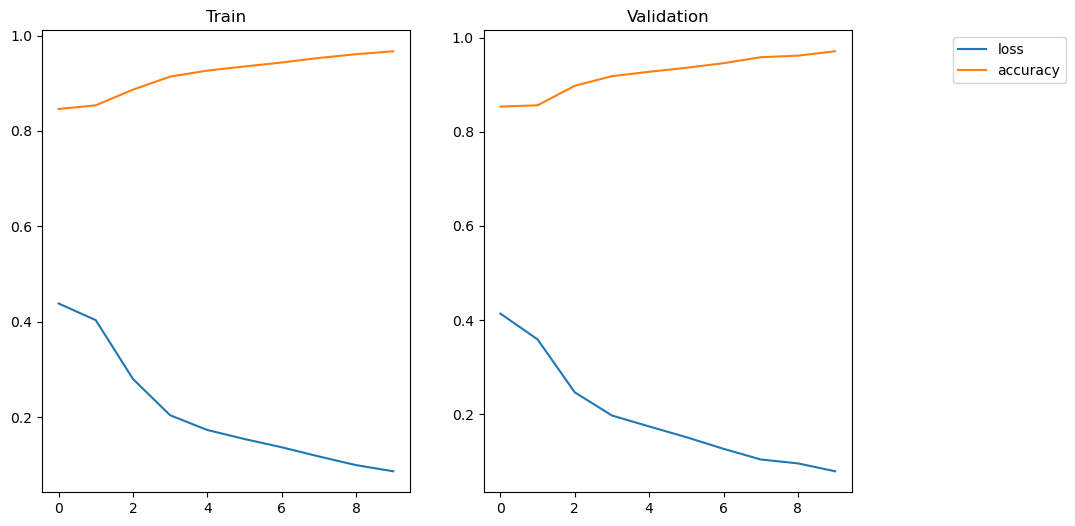

In [9]:
loss_history = history.history

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].set_title('Train')
ax[0].plot(loss_history['loss'], label='loss')
ax[0].plot(loss_history['binary_accuracy'], label='accuracy')

ax[1].set_title('Validation')
ax[1].plot(loss_history['val_loss'], label='loss')
ax[1].plot(loss_history['val_binary_accuracy'], label='accuracy')

plt.legend(loc='upper right', bbox_to_anchor=(1.6, 1.0))
plt.subplots_adjust(right=0.8)
plt.show();

## Saving and Loading

In [10]:
model.save('bee_classifier_checkpoint')

# Two options to load model with custom metrics:  provide custom_objects dictionary, or compile=False

# custom_objects dictionary is needed to restore custom metrics, to resume training from a checkpoint.
restored_model_for_training = tf.keras.models.load_model(
    'bee_classifier_checkpoint',
    custom_objects={
        'gpu_0_utilization': gpu_tracker_callback.utilization_metric(),
        'gpu_0_clock_speed': gpu_tracker_callback.clock_speed_metric(),
        'gpu_0_temperature': gpu_tracker_callback.temperature_metric(),
        'gpu_0_fan_speed': gpu_tracker_callback.fan_speed_metric(),
        'gpu_0_power_usage': gpu_tracker_callback.power_usage_metric()
    }
)

# If model is being loaded for inference, its ok to simply load it with compile=False
# and load it without metrics.
restored_model_for_inference = tf.keras.models.load_model(
    'bee_classifier_checkpoint',
    compile=False
)

INFO:tensorflow:Assets written to: bee_classifier_checkpoint\assets


INFO:tensorflow:Assets written to: bee_classifier_checkpoint\assets
